In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


Let's now import and analyze our dataset
from this link https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [0]:
movie_reviews = pd.read_csv("/content/IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [0]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
movie_reviews["review"][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

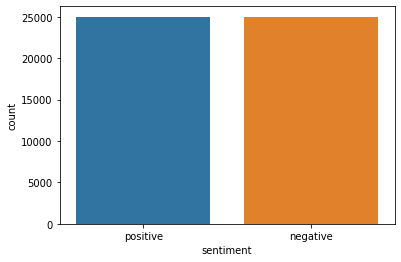

In [0]:
import seaborn as s

s.countplot(x='sentiment', data=movie_reviews)


From the output, it is clear that the dataset contains equal number of positive and negative reviews

1st stage : Data Preprocessing and cleaning

we will define a function that takes a text string as a parameter and then performs preprocessing on the string to remove special characters 

In [0]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [0]:
review = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    review.append(preprocess_text(sen))

In [0]:
review[4]

'Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us vivid portrait about human relations This is movie that seems to be telling us what money power and success do to people in the different situations we encounter This being variation on the Arthur Schnitzler play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounter The acting is good under

Next Step convert our labels into integers. Since we only have two labels in the output i.e. "positive" and "negative". convert them into integers by replacing "positive" --> 1 and negative --> 0 as shown below:

In [0]:
converted = movie_reviews['sentiment']

converted = np.array(list(map(lambda x: 1 if x=="positive" else 0, converted)))

we need to divide our dataset into train and test sets. The train set will be used to train our deep learning models while the test set will be used to evaluate how well our model performs.

In [0]:
review_train, review_test, converted_train, converted_test = train_test_split(review, converted, test_size=0.20, random_state=42)

let's now write the script for our embedding layer. The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras.

Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key. 

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)

review_train = tokenizer.texts_to_sequences(review_train)
review_test = tokenizer.texts_to_sequences(review_test)

We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called padding.

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

review_train = pad_sequences(review_train, padding='post', maxlen=maxlen)
review_test = pad_sequences(review_test, padding='post', maxlen=maxlen)

if you see review_train and review_test all the lists have same length i.e. 100. Also, the vocabulary_size variable now contains a value 92547 which means that our corpus has 92547 unique words.

we will use GloVe embeddings to create our feature matrix. In the following script we load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.

In [0]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
from keras.layers import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit(review_train, converted_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(review_test, converted_test, verbose=1)



Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 52s 2ms/step - loss: 0.5751 - acc: 0.6954 - val_loss: 0.4672 - val_acc: 0.7808
Epoch 2/6
32000/32000 [==============================] - 51s 2ms/step - loss: 0.4601 - acc: 0.7873 - val_loss: 0.4364 - val_acc: 0.7951
Epoch 3/6
32000/32000 [==============================] - 51s 2ms/step - loss: 0.4073 - acc: 0.8149 - val_loss: 0.3717 - val_acc: 0.8329
Epoch 4/6
32000/32000 [==============================] - 51s 2ms/step - loss: 0.3667 - acc: 0.8364 - val_loss: 0.3510 - val_acc: 0.8492
Epoch 5/6
32000/32000 [==============================] - 50s 2ms/step - loss: 0.3416 - acc: 0.8479 - val_loss: 0.3629 - val_acc: 0.8356
Epoch 6/6
10000/10000 [==============================] - 24s 2ms/step


In [0]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3307235056161881
Test Accuracy: 0.8539


In [0]:
instance = review[60]
print(instance)

What happened What we have here is basically solid and plausible premise and with decent and talented cast but somewhere the movie loses it Actually it never really got going There was little excitement when we find out that Angie is not really pregnant then find out that she is after all but that was it Steve Martin who is very talented person and usually brings lot to movie was dreadful and his entire character was not even close to being important to this movie other than to make it longer really would have liked to see more interactions between the main characters Kate and Angie and maybe try not for pure comedy which unfortunately it was not but maybe drama with comedic elements think if the movie did this it could have been very funny since both actresses are quite funny in their own ways and sitting here can think of numerous scenarios that would have been riot 


To predict the sentiment of this review, we have to convert this review into numeric form. We can do so using the tokenizer that we created in word embedding section. The text_to_sequences method will convert the sentence into its numeric counter part.

Next, we need to pad our input sequence as we did for our corpus. Finally, we can use the predict method of our model and pass it our processed input sequence.

In [0]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.38164043]], dtype=float32)

Remember, we mapped the positive outputs to 1 and the negative outputs to 0. However, the sigmoid function predicts floating value between 0 and 1. If the value is less than 0.5, the sentiment is considered negative where as if the value is greater than 0.5, the sentiment is considered as positive. 

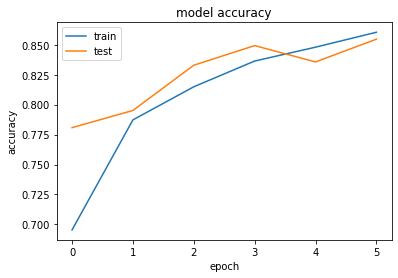

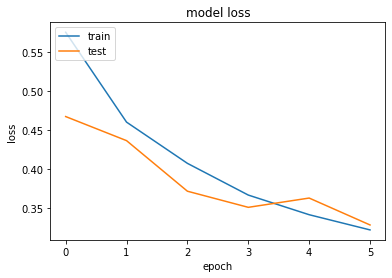

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The output shows that the difference between the accuracy values for training and test sets is much small,Similarly, the different between the loss values is also negligible, which shows that our model is not overfitting.